In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

from scipy.optimize import minimize
from scipy.stats import genextreme 

In [2]:
df = pd.read_csv("data/new_era5_data.csv",sep=";")
#Read and load data from csv file

df.time = pd.to_datetime(df.time)
#Convert string to datetime

In [3]:
#Set up start and end date of each year, deletes March 31st if leap year

day_first = pd.date_range("{}-11-01".format(np.min(df.time.dt.year)), "{}-12-01".format(np.max(df.time.dt.year)), freq='12MS')
is_leap = day_first.is_leap_year
day_last = pd.date_range("{}-03-01".format(np.min(df.time.dt.year)), "{}-03-31".format(np.max(df.time.dt.year)), freq='12ME', inclusive='right')
dt1 = day_last[~is_leap]
dt2 = day_last[is_leap] - timedelta(days=1)
day_last = pd.concat([pd.Series(dt1), pd.Series(dt2)],ignore_index=True)
day_last = day_last.sort_values(ignore_index=True)
df_times = pd.DataFrame({'day_first': pd.Series(day_first),'day_last': pd.Series(day_last).shift(-1)})
df_times["year"] = pd.Series(df_times.day_last.dt.year)
df_times = df_times.iloc[0:-1] #exclude last row
df["year"] = np.nan
for row in zip(df_times.day_first,df_times.day_last,df_times.year):
    #print(row)
    df.loc[(df['time'] >= row[0]) & (df['time'] <= row[1]), 'year'] = row[2]
df = df[df['year'].notna()]

In [4]:
#CAO index
df["cao_index"] = df["tanom_cao"] * df["cao_area_weighted"]
df["cao_index"] = df["cao_index"].fillna(0)

t_trend = df.groupby(["year"],as_index=False).agg({'year': 'mean', 'cao_index': 'min'})
t_trend["rolling"] = t_trend["cao_index"].rolling(10,center=True).mean()

duration = np.zeros(np.shape(t_trend)[0])
idx_peak = np.zeros(np.shape(t_trend)[0])
res_list = list()
for i,cao in enumerate(t_trend.cao_index):
    #ii = np.argwhere(df['cao_index']==cao)
    ii = np.nonzero(df['cao_index']==cao)[0][0]
    selected_data = df['cao_index'].iloc[range(ii-2,ii+3)]
    res_list.append(selected_data.reset_index()['cao_index'])
    idx_peak[i]=ii
    duration[i] = np.sum(selected_data)

t_trend["duration"] = duration

In [5]:
def neg_log_likelihood(params,data):
    F = lambda x: genextreme.logpdf(x,*params)
    result = -sum(F(_) for _ in data)
    return result

#Using parametric bootstrap for parameter error estimation
def bootstrap_covar(xi,mu,sigma,obs,n_bootstrap=1000):
    N = len(obs)
    bootstrap_params = np.zeros((n_bootstrap, 3))
    for i in range(n_bootstrap):
        synthetic_data = genextreme.rvs(xi, loc=mu, scale=sigma, size=N)
        #result = minimize(neg_log_likelihood, initial_guess, args=(synthetic_data,), 
        #                     method='Nelder-Mead')
        #bootstrap_params[i] = result.x
        result = genextreme.fit(synthetic_data)
        bootstrap_params[i] = np.array([result[1],result[2],-result[0]]) #order like in the extreme book

    vcov_matrix = np.cov(bootstrap_params, rowvar=False)
    return vcov_matrix #variance-covariance matrix, variances of each parameter in the main diagonal

def return_interval(mu,sigma,xi,p):
    y = -np.log(1-p)
    z = mu - sigma/xi * (1 - (y)**(-xi))
    return z

def return_interval_std(sigma,xi,p,vcov_matrix):
    y = -np.log(1-p)
    vcov_zp = np.array([1,-(1/xi)*(1-(y)**(-xi)),sigma * xi**(-2)*(1-(y)**(-xi))- sigma* (xi**(-1))* (y**(-xi)) *np.log(y)])
    var_z = np.matmul(np.matmul(vcov_zp.T, vcov_matrix),vcov_zp)
    std_z = np.sqrt(var_z)
    return std_z

In [6]:
N=t_trend.shape[0]
#i = np.linspace(1,N,N)
#p = i/(N+1)
#xp = 1 - p


# Estimated return periods changing observational period

In [7]:
def get_obs_for_sim(data,VAR = 'VAR'):
    
    N=data.shape[0]
    data = data.sort_values(VAR)

    obs_rank = data[VAR]
    obs_rank = obs_rank
    p_obs = np.ones(N)
    for i in range(N): 
        p_obs[i] = ((i+1)/(N+1))

    obs = data[VAR]
    return(obs)

def subset_data(data,n_sim):
    #sim =1 pre 1979 data / sim = 2 pos 1979 data / sim = 0 ou sim = 3 full data
    if n_sim ==1:
        return(data.loc[data.year<1979])
    elif n_sim == 2:
        return(data.loc[data.year>=1979])
    else:
        return(data)

In [8]:
sim = 0 #full data
extreme_obs = get_obs_for_sim(subset_data(t_trend,sim))
extreme_obs = extreme_obs.iloc[[-1,-2,-3]].reset_index(drop=True)
extreme_obs

KeyError: 'VAR'

In [ ]:
VAR="cao_index"
t_trend["VAR"] = -t_trend[VAR]

obs_rank = t_trend["VAR"].sort_values()
obs_rank = obs_rank
p_obs = np.ones(N)
for i in range(N): 
    p_obs[i] = ((i+1)/(N+1))

obs_return = 1/(1-p_obs)

In [ ]:
n_sims = 3
xi = np.zeros(n_sims)
mu = np.zeros(n_sims)
sigma = np.zeros(n_sims)

p = np.linspace(0,1,1000)
p = p[1:]

z_p = np.zeros((n_sims,len(p)))
z_p_std = np.zeros((n_sims,len(p)))
lower_bound =np.zeros((n_sims,len(p)))
upper_bound = np.zeros((n_sims,len(p)))

for sim in range(0,n_sims):
    print(sim)
    obs = get_obs_for_sim(subset_data(t_trend,sim))
    gev_params = genextreme.fit(obs)
    xi[sim] = -gev_params[0]
    mu[sim] = gev_params[1]
    sigma[sim] = gev_params[2]

    vcov_matrix = bootstrap_covar(-xi[sim],mu[sim],sigma[sim],obs,n_bootstrap=1000)

    z_p[sim,:] = np.array([return_interval(mu[sim],sigma[sim],xi[sim],_) for _ in p])
    z_p_std[sim,:] = np.array([return_interval_std(sigma[sim],xi[sim],_,vcov_matrix) for _ in p])
    lower_bound[sim,:] = z_p[sim,:] - 1.96*z_p_std[sim,:]
    upper_bound[sim,:] = z_p[sim,:] + 1.96*z_p_std[sim,:]


0


/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_2025/1369729724.py:22: RuntimeWarning: divide by zero encountered in log
  y = -np.log(1-p)
/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_2025/1369729724.py:27: RuntimeWarning: divide by zero encountered in log
  y = -np.log(1-p)
/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_2025/1369729724.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  vcov_zp = np.array([1,-(1/xi)*(1-(y)**(-xi)),sigma * xi**(-2)*(1-(y)**(-xi))- sigma* (xi**(-1))* (y**(-xi)) *np.log(y)])


1
2


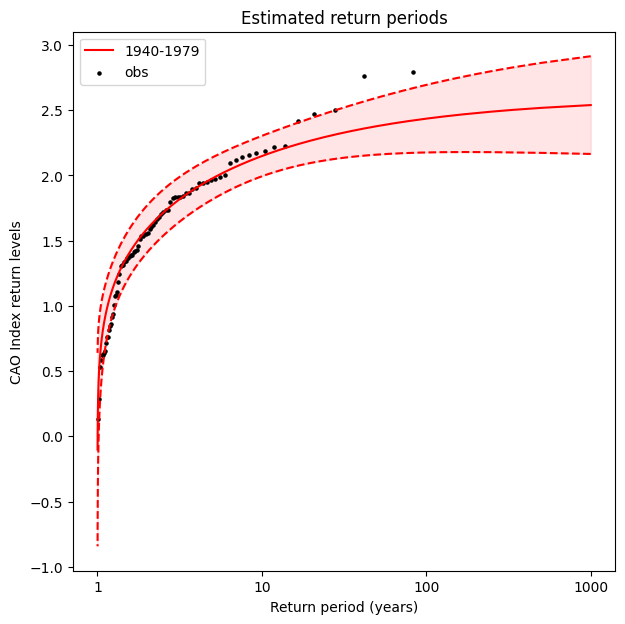

In [ ]:
colors = ["blue","red","orange"]
label = ["full","1940-1979","1979-2022"]
sim=0
fig, ax = plt.subplots(figsize=(7, 7))
#for sim in range(1,n_sims):
for sim in range(1,2):
    plt.plot(np.log10(1/p),z_p[sim],color=colors[sim],label=label[sim])
    plt.fill_between(np.log10(1/p), lower_bound[sim], upper_bound[sim], color=colors[sim], alpha=0.1)
    plt.plot(np.log10(1/p),lower_bound[sim],linestyle="--",color=colors[sim])
    plt.plot(np.log10(1/p),upper_bound[sim],linestyle="--",color=colors[sim])
plt.scatter(np.log10(obs_return),obs_rank,s=5,color="black",label="obs")
plt.title('Estimated return periods')
plt.legend()
plt.ylabel("CAO Index return levels")
plt.xlabel("Return period (years)")
#x axis labels
ax.set_xticks(np.array([0,1,2,3]), labels=[1,10,100,1000])
plt.show()

In [ ]:
print("mu:",mu,"sigma:",sigma,"xi:",xi)

mu: [1.33999139 1.41726734 1.2947754 ] sigma: [0.57617114 0.50572979 0.63174081] xi: [-0.33081969 -0.42718481 -0.32343333]


# Verifying the 1940-1978 GEV fit

In [ ]:
n_sims=3
obs_rank_list = list()
obs_return_list = list()

for sim in range(0,n_sims):
    temp = t_trend
    VAR="cao_index"
    temp["VAR"] = -temp[VAR]
    temp = subset_data(temp,sim)
    N = len(temp["VAR"])
    obs_rank = np.array(temp["VAR"].sort_values())
    p_obs = np.ones(N)
    for i in range(N): 
        p_obs[i] = ((i+1)/(N+1))

    obs_return = 1/(1-p_obs)

    obs_rank_list.append(obs_rank)
    obs_return_list.append(obs_return)

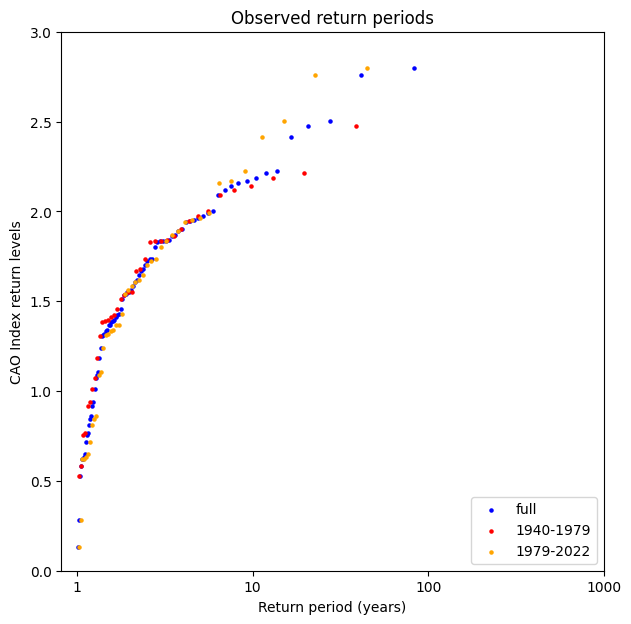

In [ ]:
colors = ["blue","red","orange"]
label = ["full","1940-1979","1979-2022"]
fig, ax = plt.subplots(figsize=(7, 7))
for sim in range(0,n_sims):
    plt.scatter(np.log10(obs_return_list[sim]),obs_rank_list[sim],s=5,color=colors[sim],label=label[sim])
ax.set_xticks(np.array([0,1,2,3]), labels=[1,10,100,1000])
plt.title('Observed return periods')
plt.legend(loc='lower right')
plt.ylabel("CAO Index return levels")
plt.xlabel("Return period (years)")
plt.ylim(0,3)
plt.show()

In [ ]:
n_sims = 3
xi = np.zeros(n_sims)
mu = np.zeros(n_sims)
sigma = np.zeros(n_sims)

p = np.linspace(0,1,1000)
p = p[1:]

z_p = np.zeros((n_sims,len(p)))
z_p_std = np.zeros((n_sims,len(p)))
lower_bound =np.zeros((n_sims,len(p)))
upper_bound = np.zeros((n_sims,len(p)))

for sim in range(0,n_sims):
    print(sim)
    obs = get_obs_for_sim(subset_data(t_trend,sim))
    gev_params = genextreme.fit(obs)
    xi[sim] = -gev_params[0]
    mu[sim] = gev_params[1]
    sigma[sim] = gev_params[2]

    vcov_matrix = bootstrap_covar(-xi[sim],mu[sim],sigma[sim],obs,n_bootstrap=1000)

    z_p[sim,:] = np.array([return_interval(mu[sim],sigma[sim],xi[sim],_) for _ in p])
    z_p_std[sim,:] = np.array([return_interval_std(sigma[sim],xi[sim],_,vcov_matrix) for _ in p])
    lower_bound[sim,:] = z_p[sim,:] - 1.96*z_p_std[sim,:]
    upper_bound[sim,:] = z_p[sim,:] + 1.96*z_p_std[sim,:]

0


/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1036/1369729724.py:22: RuntimeWarning: divide by zero encountered in log
  y = -np.log(1-p)
/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1036/1369729724.py:27: RuntimeWarning: divide by zero encountered in log
  y = -np.log(1-p)
/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_1036/1369729724.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  vcov_zp = np.array([1,-(1/xi)*(1-(y)**(-xi)),sigma * xi**(-2)*(1-(y)**(-xi))- sigma* (xi**(-1))* (y**(-xi)) *np.log(y)])


1
2


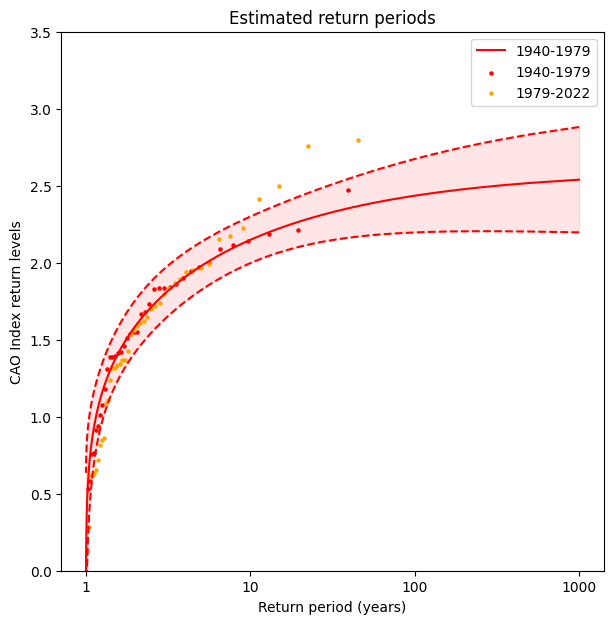

In [ ]:
colors = ["blue","red","orange"]
label = ["full","1940-1979","1979-2022"]
sim=1
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(np.log10(1/p),z_p[sim],color=colors[sim],label=label[sim])
plt.fill_between(np.log10(1/p), lower_bound[sim], upper_bound[sim], color=colors[sim], alpha=0.1)
plt.plot(np.log10(1/p),lower_bound[sim],linestyle="--",color=colors[sim])
plt.plot(np.log10(1/p),upper_bound[sim],linestyle="--",color=colors[sim])
plt.scatter(np.log10(obs_return_list[1]),obs_rank_list[1],s=5,color="red",label="1940-1979")
plt.scatter(np.log10(obs_return_list[2]),obs_rank_list[2],s=5,color="orange",label="1979-2022")

plt.title('Estimated return periods')
plt.legend()
plt.ylabel("CAO Index return levels")
plt.xlabel("Return period (years)")
#x axis labels
ax.set_xticks(np.array([0,1,2,3]), labels=[1,10,100,1000])
plt.ylim(0,3.5)
plt.show()